In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from math import sqrt, exp, inf

In [15]:
df = pd.DataFrame(columns=['Customer Number','X Coord','Y Coord','Demand', 'Ready Time', 'Due Time', 'Service Time','Vehicle Number','Vehicle Capacity'])
df.head()

,Customer Number,X Coord,Y Coord,Demand,Ready Time,Due Time,Service Time,Vehicle Number,Vehicle Capacity


In [16]:
cust_num = 0
text_file = 'Data\\c102.txt'
with open(text_file, 'rt', newline='') as fo:
    for line_count, line in enumerate(fo, start=1):
        if line_count == 5:
            values = line.strip().split()
            vehicle_number = float(values[0])
            vehicle_capacity = float(values[1])
        if line_count >= 10:
            values = line.strip().split()
            df.loc[cust_num] = [float(values[0]),float(values[1]),float(values[2]),float(values[3]),float(values[4]),float(values[5]),float(values[6]),vehicle_number,vehicle_capacity]
            cust_num += 1
        else:
            pass

In [17]:
df.head(20)

,Customer Number,X Coord,Y Coord,Demand,Ready Time,Due Time,Service Time,Vehicle Number,Vehicle Capacity
0,0.0,40.0,50.0,0.0,0.0,1236.0,0.0,25.0,200.0
1,1.0,45.0,68.0,10.0,0.0,1127.0,90.0,25.0,200.0
2,2.0,45.0,70.0,30.0,0.0,1125.0,90.0,25.0,200.0
3,3.0,42.0,66.0,10.0,0.0,1129.0,90.0,25.0,200.0
4,4.0,42.0,68.0,10.0,727.0,782.0,90.0,25.0,200.0
5,5.0,42.0,65.0,10.0,0.0,1130.0,90.0,25.0,200.0
6,6.0,40.0,69.0,20.0,621.0,702.0,90.0,25.0,200.0
7,7.0,40.0,66.0,20.0,0.0,1130.0,90.0,25.0,200.0
8,8.0,38.0,68.0,20.0,255.0,324.0,90.0,25.0,200.0
9,9.0,38.0,70.0,10.0,534.0,605.0,90.0,25.0,200.0


In [18]:
print(len(df))

101


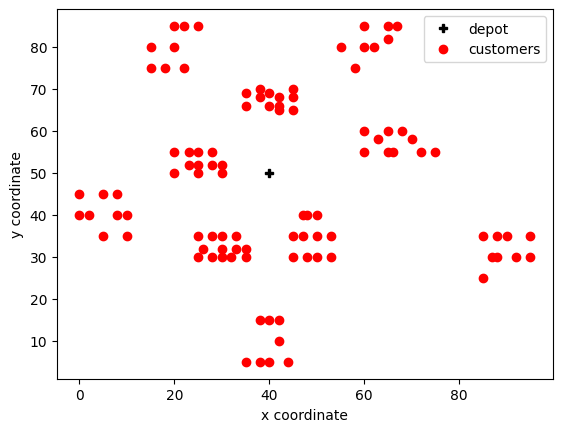

In [19]:
customer_number = 100

dep, = plt.plot(df.loc[0,'X Coord'], df.loc[0,'Y Coord'], 'kP', label='depot')
for customer_id in range(1,customer_number):
    custs, = plt.plot(df.loc[customer_id,'X Coord'], df.loc[customer_id,'Y Coord'], 'ro', label='customers')

plt.ylabel("y coordinate")
plt.xlabel("x coordinate")
plt.legend([dep, custs], ['depot', 'customers'], loc=1)
plt.show()

## PSO

In [20]:
def Ecl_distance(p1, p2):
    return sqrt((p1.loc['X Coord']-p2.loc['X Coord'])**2+(p1.loc['Y Coord']-p2.loc['Y Coord'])**2)

In [21]:
test1=df.loc[1]
test2=df.loc[2]
print(Ecl_distance(test1,test2))

2.0


In [22]:
def create_route_from_ind(data, individual):
    route = []
    subroute = []
    set_capacity = data.loc[1,'Vehicle Capacity']
    vehicle_load = 0
    previous_cust_id = 0
    elapsed_time = 0
    depot_due_time = data.loc[0,'Due Time']
    data_len = len(data)-1

    customer_indx = list(range(1, data_len))  # Exclude depot (0)
    sorted_indx = sorted(customer_indx, key=lambda i: individual[i-1], reverse=True)

    for cust_id in sorted_indx:
        demand = data.loc[cust_id,'Demand']
        updated_vehicle_load = vehicle_load + demand

        service_time = data.loc[cust_id,'Service Time']
        moving_time = Ecl_distance(data.loc[cust_id],data.loc[previous_cust_id])
        return_time = Ecl_distance(data.loc[cust_id],data.loc[0])
        updated_elapsed_time = elapsed_time + service_time + moving_time + return_time

        if(updated_vehicle_load <= set_capacity) and (updated_elapsed_time <= depot_due_time):
            subroute.append(cust_id)
            vehicle_load = updated_vehicle_load
            elapsed_time = updated_elapsed_time - return_time
        else:
            route.append(subroute)
            subroute = [cust_id]
            vehicle_load = demand
            moving_time = Ecl_distance(data.loc[cust_id],data.loc[0])
            elapsed_time = service_time + moving_time
        previos_cust_id = cust_id
    if(subroute):
        route.append(subroute)
    
    return route

In [23]:
def calculate_fitness(data, individual):

    transport_cost = 8.0  # cost of moving 1 vehicle for 1 unit
    vehicle_setup_cost = 50.0  # cost of adapting new vehicle
    wait_penalty = 0.5  # penalty for arriving too early
    delay_penalty = 3.0  # penalty for arriving too late

    route = create_route_from_ind(data, individual)
    total_cost = inf
    fitness = 0
    max_vehicles_count = 25

    # checking if we have enough vehicles
    if len(route) <= max_vehicles_count:
        total_cost = 0
        for sub_route in route:
            sub_route_time_cost = 0
            sub_route_distance = 0
            elapsed_time = 0
            previous_cust_id = 0
            for cust_id in sub_route:
                # Calculate section distance
                distance = Ecl_distance(data.loc[cust_id],data.loc[previous_cust_id])
                # Update sub-route distance
                sub_route_distance = sub_route_distance + distance

                # Calculate time cost
                arrival_time = elapsed_time + distance

                waiting_time = max(data.loc[cust_id, 'Ready Time'] - arrival_time, 0)
                delay_time = max(arrival_time - data.loc[cust_id, 'Due Time'], 0)
                time_cost = wait_penalty * waiting_time + delay_penalty * delay_time

                # Update sub-route time cost
                sub_route_time_cost += time_cost

                # Update elapsed time
                service_time = data.loc[cust_id, 'Service Time']
                elapsed_time = arrival_time + service_time

                # Update last customer ID
                previous_cust_id = cust_id

            # Calculate transport cost
            distance_depot = Ecl_distance(data.loc[previous_cust_id],data.loc[0])
            sub_route_distance += distance_depot
            sub_route_transport_cost = vehicle_setup_cost + transport_cost * sub_route_distance
            # Obtain sub-route cost
            sub_route_cost = sub_route_time_cost + sub_route_transport_cost
            # Update total cost`
            total_cost += sub_route_cost

        # fitness = - math.log(1.0 / total_cost)
        fitness = total_cost

    return fitness

In [24]:
class Particle:
    def __init__(self, data, num_dimension):
        self.position = []
        self.velocity = []
        self.pbest_position = self.position
        self.pbest_fitness = -1
        self.p_fitness = -1
        self.data = data
        self.raise_flag = 0
    
        for i in range(0, num_dimension):
            self.position.append(random.uniform(-5,5))
            self.velocity.append(random.uniform(-1,1))
    
    def evaluate(self):
        self.p_fitness = calculate_fitness(self.data, self.position)
        if self.pbest_fitness == -1 or self.pbest_fitness < self.p_fitness:
            self.pbest_fitness = self.p_fitness
            self.pbest_position = self.position.copy()
            self.raise_flag = 0
        else:
            self.raise_flag = 1
    
    def update_velocity(self, d_num, gbest_position, iter_num, iter_max):
        #CLPSO velocity v_i = w*v_i + c*r_i*(pbest_fid - x_i)
        w_max = 0.9
        w_min = 0.4
        c = 1.49445

        r = random.uniform(0,1)
        g = iter_num
        G = iter_max
        w = w_max - (w_max - w_min)*(g/G)
        self.velocity[d_num] = w*self.velocity[d_num] + c*r*(gbest_position[d_num] - self.position[d_num])

    def update_position(self, d_num):
        self.position[d_num] = self.position[d_num] + self.velocity[d_num]

    def print(self):
        print(self.position, '', self.velocity)

In [25]:
class PSO():
    def __init__(self, data, num_dimensions, num_particles, max_iter):
        num_dimensions = num_dimensions
        gbest_fitness = -1
        gbest_position = []
        r = []
        flag = -1

        swarm = []
        for i in range(0,num_particles):
            swarm.append(Particle(data, num_dimensions))
        
        for i in range(max_iter):
            for j in range(0, num_particles):
                swarm[j].evaluate()
                pci = 0.05 + 0.45*((exp((10*(j-1))/(num_particles-1))-1)/(exp(10)-1))
                n = 2

                for k in range(0, num_dimensions):
                    r.append(random.uniform(0,1))

                exemplar = list(range(0, num_particles))
                exemplar.remove(j)
                random.shuffle(exemplar)

                if(flag != -1):
                    if(swarm[j].raise_flag == 1):
                        flag += 1
                    else:
                        flag = 0

                if(flag >= 7 or flag == -1):
                    best_fitness = inf
                    better_part_idx = -1
                    number_of_exemplar = n
                    for n in range(number_of_exemplar):
                        if(swarm[exemplar[n]].pbest_fitness < best_fitness):
                            best_fitness = swarm[exemplar[n]].pbest_fitness 
                            better_part_idx = n
                    exemplar_position = list(swarm[exemplar[better_part_idx]].position)
                    flag = 0
                    
                for d in range (0, num_dimensions):
                    if(r[d] < pci):
                        swarm[j].update_velocity(d_num=d, gbest_position=exemplar_position, iter_num=i, iter_max=max_iter)
                        swarm[j].update_position(d_num=d)
                    else:
                        swarm[j].update_velocity(d_num=d, gbest_position=swarm[j].pbest_position, iter_num=i, iter_max=max_iter)
                        swarm[j].update_position(d_num=d)

        for i in range(max_iter):
            for j in range(0, num_particles):
                swarm[j].evaluate()
                if swarm[j].p_fitness < gbest_fitness or gbest_fitness == -1:
                    gbest_position = list(swarm[j].position)
                    gbest_fitness = float(swarm[j].pbest_fitness)

        
        print('FINAL:')
        print(gbest_position)
        print(gbest_fitness)
        print()

        pos = gbest_position
        customer_indx = list(range(1, len(df)-1))  # Exclude depot (0)
        sorted_indx = sorted(customer_indx, key=lambda i: pos[i-1], reverse=True)
        route = create_route_from_ind(df, sorted_indx)

        print(route)

In [26]:
PSO(data = df, num_dimensions = len(df)-1, num_particles=25, max_iter=200)

FINAL:
[2.729367509745014, 3.7813114382530677, 0.7733081855838941, 0.8916880035076296, 1.378928735394807, -4.257105122221924, -3.5106745433080335, 4.522161597017154, -1.6512702509916206, -3.9169656965694473, -3.2777817553533333, 6433397344.782561, -5.123822350495921, -1.2656055757043392, 4.732340218062548, -1.584800307264297, -3.045573549769992, -4.219467711197996, 3.955631253076049, -1.7088605934851835, 0.33505295995215556, 1.7067780185927561, -0.04612154663999921, 2.436694135055444, 0.7239780926029461, 3.6974904240024564, -227.09839625708, -4.006834623566618, 3.738257201253951, -2.2388725113637094, 4.7608794889745845, -2.6914518570414945, -25112739068.26124, 3.187594268655454, -5.938615368041678, 2.6757644444931596, 1.0795535080027001, 2.72386157779851, -5.0643820832222115, 5.146018549914651, 0.33613446688108983, 1.0916916339426441, 0.9895305266909764, 7.283425848340455, 2.4955898494592397, -0.44704531038214756, 0.5266310142803858, 2.939967935654002, -3.678114792731314, -0.1671798017